In [14]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
from toolbox import connect_poi
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [15]:
nodes = gpd.read_file("data/graph/nodes.shp")
edges = gpd.read_file("data/graph/edges.shp")

nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

#len(nodes)
#edges.head(30)

In [16]:
categories = ["education", "bank", "healthcare", "transportation", "food" ]
for category in categories:
    nodes[category] = False

for index, node in nodes.iterrows():
    if(node["highway"] in categories):
        for category in categories:
            nodes.at[index, category] = True


In [30]:
G = ox.utils_graph.graph_from_gdfs(nodes, edges)


<h1>Coverage</h1>
<p>Given a graph G = (nodes, edges) knowing that in the edges there are some POIs, modify the nodes table to have that: nodes below 15 minutes to at least a POI of a certain category have that category column set to true.</p>
<p>Example: Suppose node i is below 15 minutes to 2 schools, 4 supermarkets and nothing more, then these will be its column values</p>
<table>
  <tr>
    <th>education</th>    
    <th>bank</th>
    <th>healthcare</th>
    <th>transportation</th>    
    <th>food</th>
  </tr>
  <tr>
    <td>True</td>
    <td>False</td>
    <td>False</td>
    <td>False</td>
    <td>True</td>
  </tr>

<h2>Add time column (minutes) to edges</h2>

In [35]:
travel_speed = 4.5  # walking speed in km/hour
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [36]:
nodes, edges = ox.graph_to_gdfs(G)
edges.head(1)

,,,osmid,highway,oneway,reversed,length,from,to,width,u_original,v_original,geometry,time,lanes,name,maxspeed,tunnel,service,bridge,access,est_width,area,ref,junction
u,v,key,,,,,,,,,,,,,,,,,,,,,,,
0.0,235.0,0,244968982,path,0,False,262.005714,0.0,235.0,3,254672751.0,1.706766e+09,"LINESTRING (11.87233 45.42523, 11.87192 45.425...",3.49341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Plot graph with all POIs</h2>
<p>We will plot a graph with red nodes representing normal nodes and blue nodes representing POIs</p>

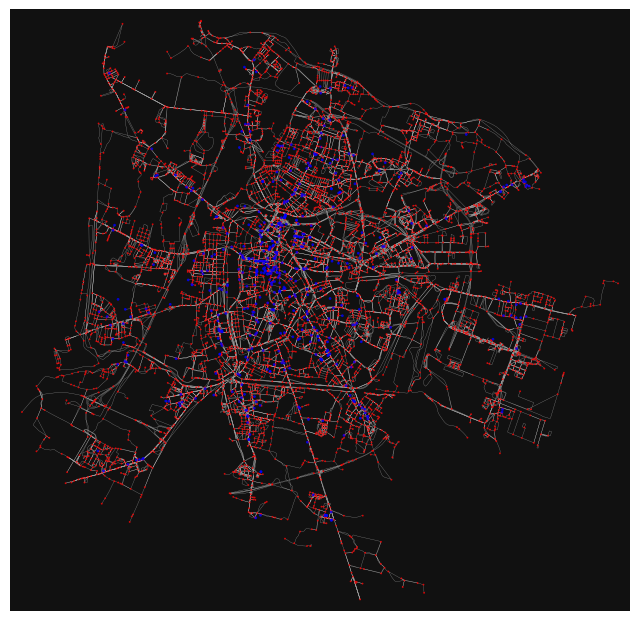

In [33]:
# color the nodes: red - normal; blue - POIs
node_colors = {}
node_sizes = {}
for node, data in G.nodes(data=True):
    node_id = node
    highway = data.get('highway', None)
    if highway in categories:
        node_colors[node_id] = "blue"
        node_sizes[node_id] = 4
    else:
        node_colors[node_id] = "red"
        node_sizes[node_id] = 1.8
        
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

<h2>Plot subgraphs with close nodes for each category</h2>
<p>Plot multiple graphs (one for each category) where blue nodes are POIs, white nodes are the one near to at least a POI, red are uncovered nodes (>15 min).</p>

<h3>Find dictionary of poi nodes</h3>
<p>Example: poi_nodes = {"food" : [1, 4, 8, 33, 45], "bank" : [...], ...} means: nodes: 1, 4, 8, 33, 45 are food POIs</p>

In [21]:
poi_nodes = {}
for category in categories:
    poi_nodes[category] = []
for node, data in G.nodes(data=True):
    node_id = node
    highway = data.get('highway', None)
    if highway in categories:
        poi_nodes[highway].append(node_id)
count_1 = 0
count_0 = 0
zero_degree_nodes = []
non_zero_degree_nodes = []
for category in categories:
    for poi in poi_nodes[category]:
        if(G.degree(poi) == 1): 
            count_1 += 1
            non_zero_degree_nodes.append(poi)
        else: 
            count_0 += 1
            zero_degree_nodes.append(poi)
print(count_1)
print(count_0)
#print((non_zero_degree_nodes))
#print((zero_degree_nodes))


139
376


<h3>Construct dictionary of close nodes for each </h3>

In [22]:
trip_time = 15

poi_nodes_example = {
    "education":[235, 48, 93, 720, 500],
    "bank":[100, 200, 300, 400, 550],
    "healthcare":[150, 250, 350, 450],
    "transportation":[125, 225, 325, 425, 525],
    "food":[998, 758, 2999, 4000, 2555],
}
subgraph_nodes = {}
for category in categories:
    subgraph_nodes[category] = []
    for poi_id in poi_nodes[category]:
        subgraph = nx.ego_graph(G, poi_id, radius=trip_time, distance="time")
        for n in subgraph.nodes():
            subgraph_nodes[category].append(n)


In [23]:
#subgraph_nodes

<h3>Update nodes table</h3>

In [24]:
for index, node in nodes.iterrows():
    for category in categories:
        if(index in subgraph_nodes[category]):
            nodes.at[index, category] = True

In [25]:
nodes

,osmid_orig,x,y,street_cou,education,bank,healthcare,transportation,food,lon,lat,highway,ref,geometry
osmid,,,,,,,,,,,,,,
0.000000e+00,"[141540485, 254672751, 197522982, 254672878, 2...",11.872335,45.425226,0.0,False,False,False,False,False,NaN,NaN,NaN,NaN,POINT (11.87233 45.42523)
2.350000e+02,"[197523004, 345286935, 1706766370, 559475298, ...",11.871946,45.426208,0.0,True,False,False,False,False,NaN,NaN,NaN,NaN,POINT (11.87195 45.42621)
2.330000e+02,243488899,11.873938,45.425744,5.0,False,False,False,False,False,11.873938,45.425744,NaN,NaN,POINT (11.87394 45.42574)
6.280000e+02,"[2522360857, 243486447, 2522360875, 2522360879...",11.873890,45.422949,0.0,False,False,False,False,False,NaN,NaN,NaN,NaN,POINT (11.87389 45.42295)
6.430000e+02,243487238,11.873258,45.425462,3.0,False,False,False,False,False,11.873258,45.425462,NaN,NaN,POINT (11.87326 45.42546)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.994000e+09,NaN,11.878924,45.414053,NaN,True,True,True,True,True,NaN,NaN,transportation,NaN,POINT (11.87892 45.41405)
9.994000e+09,NaN,11.878469,45.407614,NaN,True,True,True,True,True,NaN,NaN,transportation,NaN,POINT (11.87847 45.40761)
9.990500e+09,NaN,11.875806,45.407237,NaN,False,False,False,False,False,NaN,NaN,projected_pap,NaN,POINT (11.87581 45.40724)
